# Video classification and feature extraction using the Inflated 3D Convnet  (I3D)
Welcome! In this lab, you'll learn how to use a pre-trained network for classifying a video into an action class and for extracting features for future use. Our goal is to predict one action label a short video. The architecture we will use is the [Inflated 3D Convnet (I3D)](https://github.com/deepmind/kinetics-i3d) recently proposed by Carreira and Zisserman[1]. We will use the pretrained models provided by the authors, which are Inception-v1 I3D models trained on the Kinetics dataset training split. In their paper, they reported state-of-the-art results on the UCF101 and HMDB51 datasets from fine-tuning these models. I3D models pre-trained on Kinetics also placed first in the CVPR 2017 Charades challenge. This notebook builds upon the [demo script](https://github.com/deepmind/kinetics-i3d/blob/master/evaluate_sample.py) provided by the authors.

[1] Carreira, Joao, and Andrew Zisserman. "Quo vadis, action recognition? a new model and the kinetics dataset." 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). IEEE, 2017.

# Import libraries

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

import kinetics_i3d.i3d as i3d

/cis/home/efi/work/ar_libs/anaconda3/envs/action_detection_tf1.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Preprocessed data and pretrained model paths

In [2]:
# For RGB, the videos are resized preserving aspect ratio so that the smallest dimension is 256 pixels,
# with bilinear interpolation. Pixel values are then rescaled between -1 and 1. 
# While during test, we select the center 224x224 image crop from the video. A sample preprocessed
# video is provided in ./kinetics_i3d/data/v_CricketShot_g04_c01_rgb.npy
_IMAGE_SIZE = 224

# Number of action classes of the kinetics dataset
_NUM_CLASSES = 400

# Number of frames of the sample video
_SAMPLE_VIDEO_FRAMES = 79

_SAMPLE_PATHS = {
    'rgb': '../kinetics_i3d/data/v_CricketShot_g04_c01_rgb.npy',
    'flow': '../kinetics_i3d/data/v_CricketShot_g04_c01_flow.npy',
}

# Paths of models pretrained on imagenet and on Kinetics
_CHECKPOINT_PATHS = {
    'rgb': '../kinetics_i3d/data/checkpoints/rgb_scratch/model.ckpt',
    'flow': '../kinetics_i3d/data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': '../kinetics_i3d/data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': '../kinetics_i3d/data/checkpoints/flow_imagenet/model.ckpt',
}

# File with action names of the Kinetics dataset (400 action classes)
_LABEL_MAP_PATH = '../kinetics_i3d/data/label_map.txt'

FLAGS = tf.flags.FLAGS
print(FLAGS)

# Options to use only rgb stream (appearance), only optical flow stream (motion) or both.
# Default option: use both.
tf.flags.DEFINE_string('eval_type', 'joint', 'rgb, flow, or joint')
# The default model has been pre-trained on ImageNet and then Kinetics.
tf.flags.DEFINE_boolean('imagenet_pretrained', True, '')
tf.app.flags.DEFINE_string('f', '', 'kernel')

--flagfile: Insert flag definitions from the given file into the command line.
  (default: '')
--undefok: comma-separated list of flag names that it is okay to specify on the
  command line even if the program does not define a flag with that name.
  IMPORTANT: flags in this list that have arguments MUST use the --flag=value
  format.
  (default: '')


In [3]:
# Look into kinetics action classes

In [4]:
tf.logging.set_verbosity(tf.logging.INFO)
eval_type = FLAGS.eval_type
imagenet_pretrained = FLAGS.imagenet_pretrained

if eval_type not in ['rgb', 'flow', 'joint']:
    raise ValueError('Bad `eval_type`, must be one of rgb, flow, joint')

kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]
print(kinetics_classes)

['abseiling', 'air drumming', 'answering questions', 'applauding', 'applying cream', 'archery', 'arm wrestling', 'arranging flowers', 'assembling computer', 'auctioning', 'baby waking up', 'baking cookies', 'balloon blowing', 'bandaging', 'barbequing', 'bartending', 'beatboxing', 'bee keeping', 'belly dancing', 'bench pressing', 'bending back', 'bending metal', 'biking through snow', 'blasting sand', 'blowing glass', 'blowing leaves', 'blowing nose', 'blowing out candles', 'bobsledding', 'bookbinding', 'bouncing on trampoline', 'bowling', 'braiding hair', 'breading or breadcrumbing', 'breakdancing', 'brush painting', 'brushing hair', 'brushing teeth', 'building cabinet', 'building shed', 'bungee jumping', 'busking', 'canoeing or kayaking', 'capoeira', 'carrying baby', 'cartwheeling', 'carving pumpkin', 'catching fish', 'catching or throwing baseball', 'catching or throwing frisbee', 'catching or throwing softball', 'celebrating', 'changing oil', 'changing wheel', 'checking tires', 'che

# Sample input video  (RGB and Optical Flow)

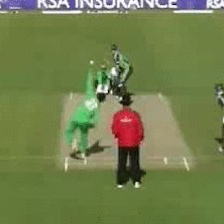

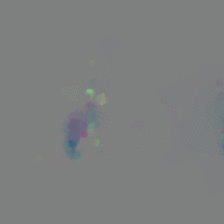

In [5]:

from IPython.display import Image
from IPython.display import display
with open('../kinetics_i3d/data/v_CricketShot_g04_c01_rgb.gif','rb') as f:
    display(Image(data=f.read(), format='gif'))
with open('../kinetics_i3d/data/v_CricketShot_g04_c01_flow.gif','rb') as f:
    display(Image(data=f.read(), format='gif'))

# Inception-V1 I3D Model Architecture (see ../kinetics_i3d/i3d.py)

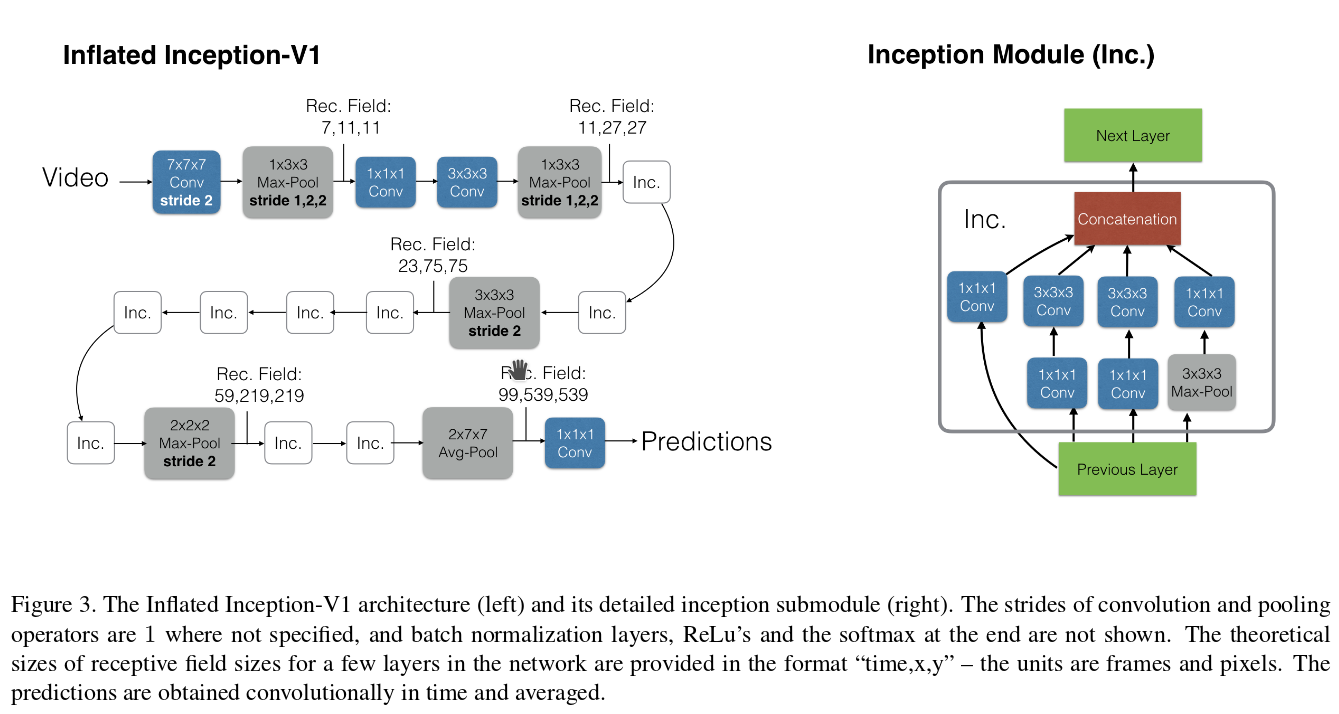

In [6]:
Image(filename='../kinetics_i3d/data/i3d_architecture.png') 

# Build model for getting scores per action class given RGB stream

In [7]:
if eval_type in ['rgb', 'joint']:
    # RGB input has 3 channels.
    rgb_input = tf.placeholder(
        tf.float32,
        shape=(1, _SAMPLE_VIDEO_FRAMES, _IMAGE_SIZE, _IMAGE_SIZE, 3))
    with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        # Get scores for each class given the rgb input
        rgb_logits, _ = rgb_model(
            rgb_input, is_training=False, dropout_keep_prob=1.0)
    rgb_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'RGB':
            rgb_variable_map[variable.name.replace(':0', '')] = variable
    rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)

# Build model for getting scores per action class given Flow stream

In [8]:
if eval_type in ['flow', 'joint']:
    # Flow input has only 2 channels.
    flow_input = tf.placeholder(
        tf.float32,
        shape=(1, _SAMPLE_VIDEO_FRAMES, _IMAGE_SIZE, _IMAGE_SIZE, 2))
    with tf.variable_scope('Flow'):
        flow_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        flow_logits, _ = flow_model(
            flow_input, is_training=False, dropout_keep_prob=1.0)
    flow_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'Flow':
            flow_variable_map[variable.name.replace(':0', '')] = variable
    flow_saver = tf.train.Saver(var_list=flow_variable_map, reshape=True)

# Fuse scores from RGB (appearance) and Optical Flow (motion) streams and apply softmax

In [9]:
if eval_type == 'rgb':
    model_logits = rgb_logits
elif eval_type == 'flow':
    model_logits = flow_logits
else:
    model_logits = rgb_logits + flow_logits
model_predictions = tf.nn.softmax(model_logits)

# Predict an action label for the input video sample by running a forward pass through the network

In [10]:
with tf.Session() as sess:
    feed_dict = {}
    if eval_type in ['rgb', 'joint']:
        if imagenet_pretrained:
            rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        else:
            rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
        tf.logging.info('RGB checkpoint restored')
        rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
        tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
        feed_dict[rgb_input] = rgb_sample

    if eval_type in ['flow', 'joint']:
        if imagenet_pretrained:
            flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
        else:
            flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
        tf.logging.info('Flow checkpoint restored')
        flow_sample = np.load(_SAMPLE_PATHS['flow'])
        tf.logging.info('Flow data loaded, shape=%s',
                        str(flow_sample.shape))
        feed_dict[flow_input] = flow_sample

    out_logits, out_predictions = sess.run(
        [model_logits, model_predictions],
        feed_dict=feed_dict)

    out_logits = out_logits[0]
    out_predictions = out_predictions[0]
    sorted_indices = np.argsort(out_predictions)[::-1]

    print('Norm of logits: %f' % np.linalg.norm(out_logits))
    print('\nTop classes and probabilities')
    for index in sorted_indices[:20]:
        print(out_predictions[index], out_logits[index],
              kinetics_classes[index])

INFO:tensorflow:Restoring parameters from ../kinetics_i3d/data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)
INFO:tensorflow:Restoring parameters from ../kinetics_i3d/data/checkpoints/flow_imagenet/model.ckpt
INFO:tensorflow:Flow checkpoint restored
INFO:tensorflow:Flow data loaded, shape=(1, 79, 224, 224, 2)
Norm of logits: 138.468674

Top classes and probabilities
1.0 41.813683 playing cricket
1.4971563e-09 21.493984 hurling (sport)
3.8430797e-10 20.134106 catching or throwing baseball
1.5492242e-10 19.225586 catching or throwing softball
1.1360122e-10 18.915356 hitting baseball
8.801105e-11 18.660124 playing tennis
2.4415511e-11 17.37788 playing kickball
1.1531971e-11 16.627785 playing squash or racquetball
6.1318893e-12 15.996164 shooting goal (soccer)
4.3917357e-12 15.662386 hammer throw
2.21341e-12 14.977197 golf putting
1.6307032e-12 14.671673 throwing discus
1.5456042e-12 14.618077 javelin